In [ ]:
# default_exp diffusion_walks

In [1]:
#export
import numpy as np
from tqdm.auto import tqdm, trange

In [2]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from rl_optimal_search.environment import isBetween_ab_Vec, target_search_onhit

In [3]:
%load_ext autoreload
%autoreload 2

# Lévy Walks

In [4]:
#export
def lw_step(alpha, num_part = 1):
    return (1 - np.random.rand(num_part))**(-1/(alpha))

In [97]:
beta = 0.5
x = np.arange(1, 1000)

num = lw_step(beta, num_part=1000000)

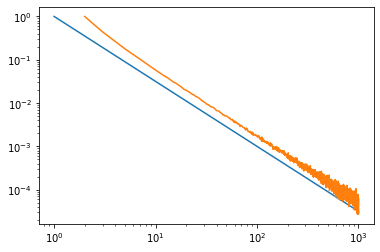

In [105]:
h, e = np.histogram(num, bins = np.linspace(1, 1e3, 1000))
theory = x**(-beta-1)
plt.loglog(x, theory)
plt.loglog(e[1:], h/h[0])

In [10]:
#export
def lw_trajs(N = 1, T = 100, alpha = 1, L = None, BC = 'reflectant'):
    
    pos = np.zeros((N, T, 2))
    
    if L is None:
        
        angles = np.random.uniform(low = 0, high = 2*np.pi, size = (N, T))
        steps = (1 - np.random.rand(N, T))**(-1/alpha)
        pos[:, :, 0], pos[:, :, 1] = [steps*np.cos(angles), steps*np.sin(angles)] 
   
        return np.cumsum(pos, axis = 1)

    else:
        
        pos = np.zeros((N, T, 2))
        pos[:, 0, :] = np.random.rand(N, 2)*L

        for t in tqdm(range(1, T)):

            angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
            steps = (1 - np.random.rand(N))**(-1/alpha)
            pos[:, t, 0] = pos[:, t-1, 0] + steps*np.cos(angles)
            pos[:, t, 1] = pos[:, t-1, 1] + steps*np.sin(angles)


        if BC == 'reflectant':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - 2*(pos[pos > L] - L)
                pos[pos < 0] = - pos[pos < 0]


        elif BC == 'periodic':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - L
                pos[pos < 0] = L + pos[pos < 0]     
        
            
        
        return pos

In [59]:
alpha = 0.5; L = 10000
N = int(1e6); T = int(1e3)

trajs = lw_trajs(N = N, T = T, alpha = alpha, L = L, BC = None)

if L is not None:
#     trajsm  = (trajs.reshape(T, N, 2) - trajs[:, 0, :]).reshape(N, T, 2)
    trajsm  = (trajs[:,:,0].transpose() - trajs[:,0,0]).transpose()


msd = np.mean(trajsm**2, axis= 0)
# msd = np.mean(msd, axis = 1)

  0%|          | 0/999 [00:00<?, ?it/s]

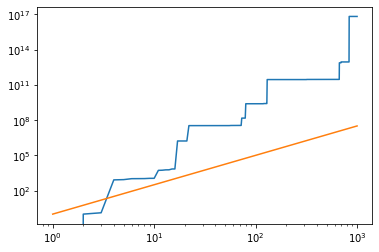

In [60]:
t = np.arange(1, msd.shape[0]+1)
plt.loglog(t, msd/msd[1], label = 'Numerics')
plt.loglog(t, t**(3-alpha))

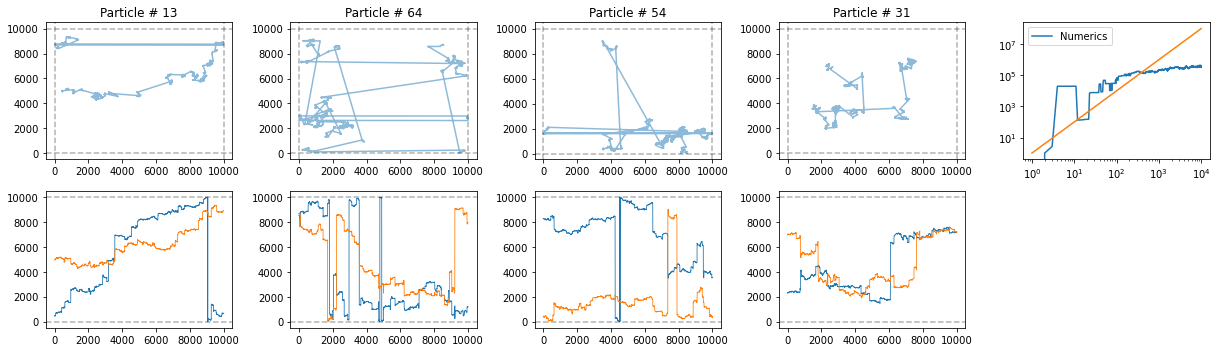

In [289]:
fig, axs = plt.subplots(2, 5, figsize = (17, 5), tight_layout = True)

for ax in axs[:, :-1].transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[part, :, 0], trajs[part, :, 1], alpha = 0.5)
    

    ax[1].plot(trajs[part, :, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[part, :, 1], '-', label = 'Y', ms = 3, lw = 0.8)

    
    if L is not None:
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
        
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    
t = np.arange(1, msd.shape[0]+1)
axs[0, -1].loglog(t, msd/msd[1], label = 'Numerics')
axs[0, -1].loglog(t, t**(3-alpha))
axs[0, -1].legend()

axs[1, -1].set_axis_off()


## Searching

In [11]:
Nt = 4000
density = 0.01
N = 2000; T = int(100)
L = Nt/density
at = 0.5
ls = 5

In [153]:
target_search_onhit(Nt = Nt, N = N, T = T, alpha = 0.1, L = L, at = at, ls = ls, sample_step = lw_step, num_part = N)

  0%|          | 0/99 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
alphas = np.linspace(0.1, 2, 8)


results = np.array(Parallel(n_jobs=len(alphas))(delayed(target_search_onhit)(Nt = Nt, N = N, T = T, sample_step = lw_step, alpha = alpha, L = L, at = at, ls = ls)
                for alpha in alphas), dtype = object)

In [8]:
    
encs = results

m_eta = np.zeros(len(alphas))
std_eta = np.zeros_like(m_eta)

for idx_a, e in enumerate(tqdm(encs)):
#     ee = e.copy()
#     ee[ee != 0] = 1
    m_eta[idx_a] = e.flatten().mean()
    std_eta[idx_a] = e.flatten().std()
    

# enc, real_steps = LW_search(Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at, ls =)

  0%|          | 0/8 [00:00<?, ?it/s]

In [158]:
std_eta

array([0.09937244, 0.09826971, 0.09934911, 0.09978308, 0.10086596,
       0.1004207 , 0.09999338, 0.09995802])

Text(0.5, 1.0, '$l_s =$ 1')

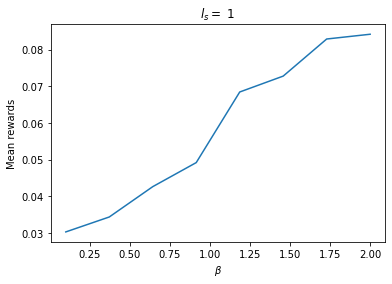

In [9]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 150')

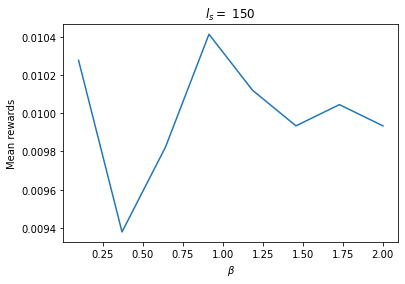

In [148]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 0.6')

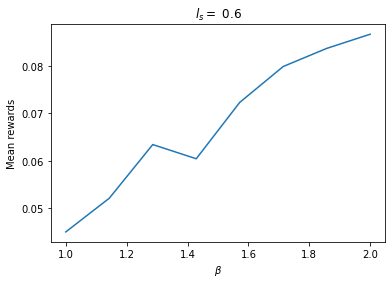

In [130]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 0.6')

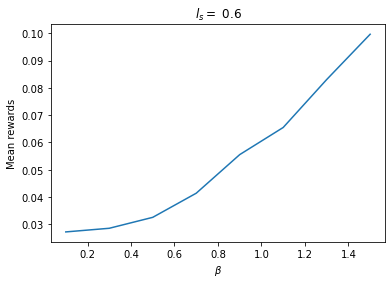

In [114]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 3')

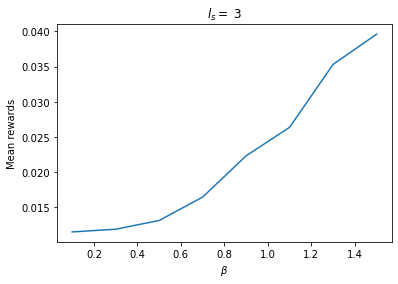

In [108]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

In [14]:
steps = results[:, 1]    

In [21]:
real_steps = []
for s in steps:
    real_steps += s

In [25]:
h, e = np.histogram(real_steps, bins = 50);

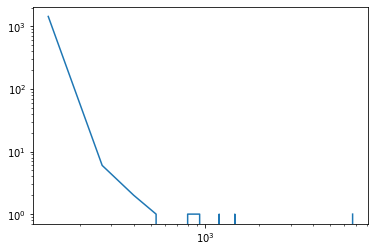

In [26]:
plt.loglog(e[1:], h)

In [56]:
pos = np.random.rand(3,5,6)
pos[(pos < 0.2) | (pos > 0.8)] = -123

## Results

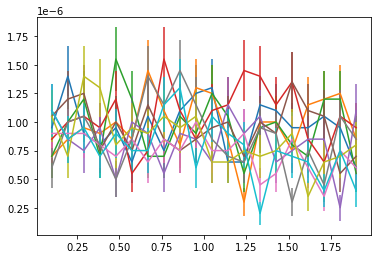

In [31]:
for m, s in zip(m_eta, std_eta):
    plt.errorbar(alphas, m, yerr=s/np.sqrt(N*T))
#     plt.show()

<ErrorbarContainer object of 3 artists>

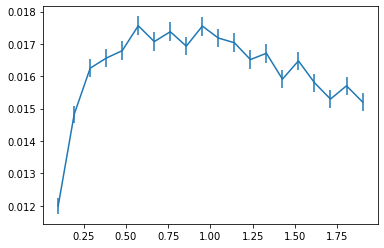

In [24]:
plt.errorbar(alphas, m_eta, yerr=std_eta/np.sqrt(e.shape[0]*e.shape[1]))

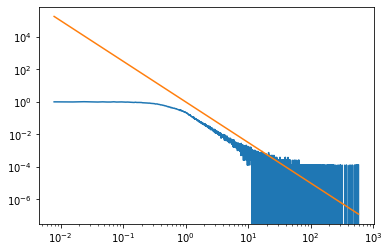

In [25]:
h, e = np.histogram(real_steps, bins = int(len(real_steps)*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [28]:
np.ceil(real_steps[:100])

array([1., 1., 1., 1., 1., 1., 4., 2., 3., 1., 5., 7., 1., 1., 1., 1., 2.,
       2., 2., 8., 2., 2., 2., 1., 1., 1., 1., 1., 4., 8., 1., 3., 1., 4.,
       1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 2.,
       1., 1., 1., 4., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1.])

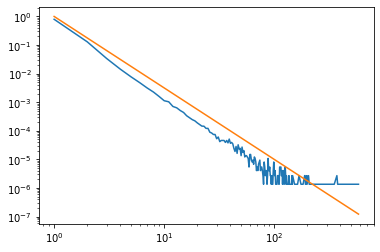

In [34]:
int_steps = np.ceil(real_steps)
h, e = np.unique(int_steps, return_counts=True)
plt.loglog(h, e/np.sum(e))
plt.plot(h, h**(-alpha-1))

In [9]:

70%30

10

In [34]:
len(enc[1])

9498

In [39]:
alpha = 1

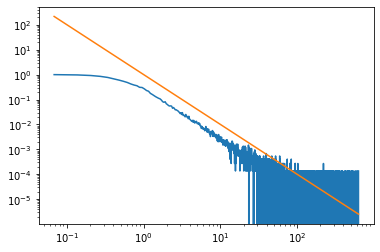

In [44]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

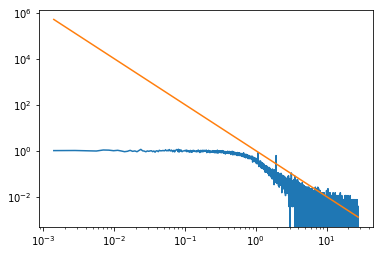

In [12]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [18]:
e

array([2.37023094e-06, 1.40173495e-03, 2.80109966e-03, ...,
       2.79802998e+01, 2.79816992e+01, 2.79830986e+01])

In [17]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
e = e[:-1]
h[e == 1] =

143334

In [27]:
Nt = 1000
N = 10000; T = int(1e4)
L = 450 
at = 0.5

alphas = np.linspace(0.2, 2, num = 18)
pos_alpha = np.zeros((len(alphas), N, T, 2))
encounter_alpha = np.zeros((len(alphas), N, T, 2))


info = Parallel(n_jobs=18)(delayed (LW_search) (Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at)
                                    for alpha in alphas)
    

MemoryError: Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64

In [29]:
enc = np.zeros(len(alphas))
mean = np.zeros(len(alphas))
std = np.zeros(len(alphas))



for idx, ia in enumerate(info):
    enc[idx] = np.sum(ia[1])
    totalN = np.sum(ia[1], axis = 1)
    mean[idx] = np.mean(totalN)
    std[idx] = np.std(totalN)

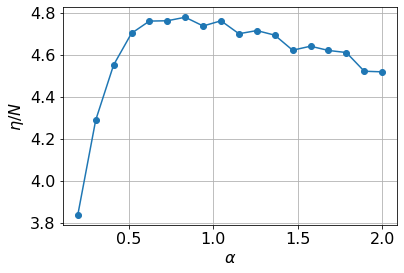

In [57]:
plt.plot(alphas, mean, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta / N$')
plt.grid('on')

# Multi-exponential 

In [70]:
#export
def multiexp_dist(x, ws, ds):
    val = 0
    for wi, di in zip(ws, ds):
        # discrete normalization from 1 to inf
        norm = (wi/di)/(np.exp(1/di)-1)
        val += (1/norm)* (wi/di) * np.exp(- x / di) 
    return val/len(ws)

In [81]:
def binomial(x, d_int, d_ext, w):
    return w*(1-np.exp(-1/d_int))*np.exp(-(x-1)/d_int)+(1-w)*(1-np.exp(-1/d_ext))*np.exp(-(x-1)/d_ext)

In [71]:
x = np.arange(1, 3000)

pdf1 = multiexp_dist(x, [0.95, 0.05], [0.05, 1e3])

In [83]:
np.sum(binomial(x, 0.05, 10000, 0.95))

0.9629553846895856

In [94]:
pdf = binomial(x = x, d_int = 0.05, d_ext = d_ext, w = 0.95)
pdf /= np.sum(pdf)
np.random.choice(np.arange(1, 3000), p = pdf)

1

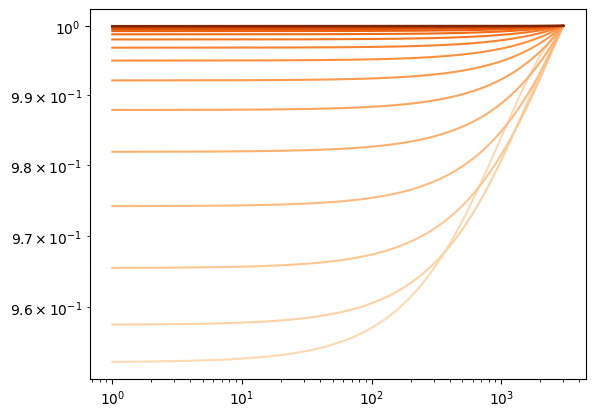

In [113]:
d_exts = np.logspace(3, 7, 20)
cmap = plt.get_cmap('Oranges')
colors = cmap(np.linspace(0.2,1, len(d_exts)))
norm = []
for d_ext, c in zip(d_exts, colors):
    pdf = binomial(x = x, d_int = 0.05, d_ext = d_ext, w = 0.95)
    pdf /= np.sum(pdf)
    
    # sample = np.random.choice(np.arange(1, 3000), size = int(1e4), p = pdf)
        
        
    # plt.loglog(x, pdf, c = c)
    plt.loglog(np.arange(1, len(pdf)+1), np.cumsum(pdf), c=c)
    norm.append(pdf[0])

In [109]:
np.sum(pdf)

0.9999999999999998

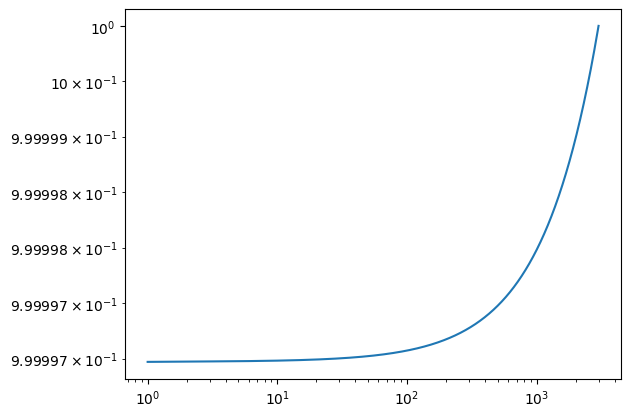

In [111]:
plt.loglog(np.arange(1, len(pdf)+1), np.cumsum(pdf))

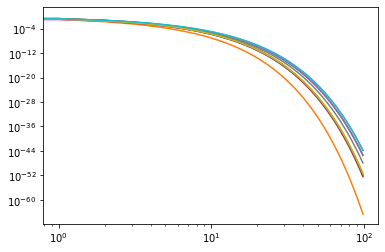

In [23]:
for idx in range(10):
    ws = np.arange(3)
    ws[0] = (10**idx)
    ws = ws/np.sum(ws)
    ds = np.random.rand(3)
    b = multiexp_dist(np.arange(1, 100), ws, ds)

    plt.loglog(b)
# plt.ylim(ymin = 1e-3)

In [41]:
#export
def discrete_multiexp_step(ws, ds, L_max=1000, num_samples = 1):
    probs = multiexp_dist(np.arange(1, L_max), ws, ds)
    probs /= np.sum(probs)
    return np.random.choice(np.arange(1, L_max), p = probs, size = num_samples)

In [24]:
samples = discrete_multiexp_step(ws, ds, num_samples=int(1e6))

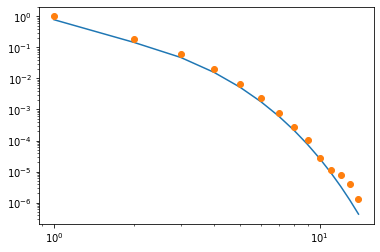

In [25]:
ls = np.arange(1, np.max(samples)+1)
true = multiexp_dist(ls, ws, ds)
u, c = np.unique(samples, return_counts = True)
# true[true < 1e-5] = 1e-5
plt.loglog(ls , true)
plt.loglog(u, c/np.max(c), 'o')


# MFPT of a 1D RW

In [26]:
from tqdm.notebook import tqdm

In [ ]:
class rw_1d():
    def __init__(self, x0 = 0, deltat = 1):
        self.deltat = deltat
        self.pos = x0
    def step(self):
        self.pos += np.

In [10]:
N = int(1e4)
T = int(1e4)
trajs = 2*np.random.randint(0, 2, size = (N,T))-1
trajs[:,0] = 0
trajs = trajs.cumsum(axis = 1)

In [24]:
abs_t = np.abs(trajs.copy())
L = 10
diff = L - abs_t 
bound = np.argwhere(diff == 0)

In [33]:
import matplotlib.pyplot as plt

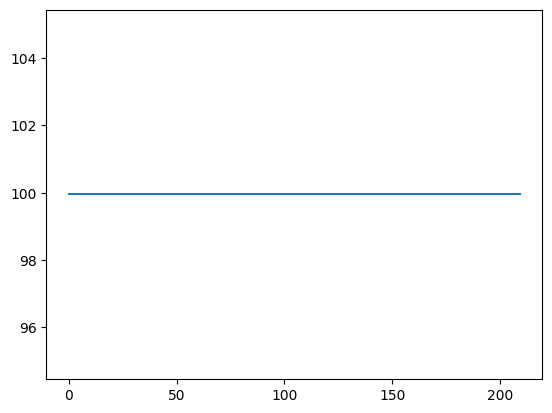

In [34]:
plt.plot(mfpt)

In [35]:
bound[bound[:,0] == u, 1][0]

62

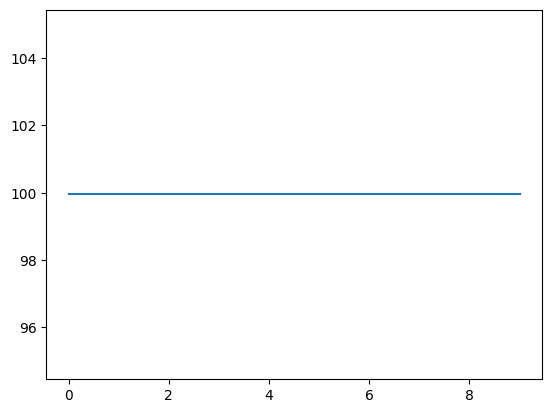

In [39]:
plt.plot(mfpt)

In [65]:
len(mfpt)

490

(8.224224799067345, 100)

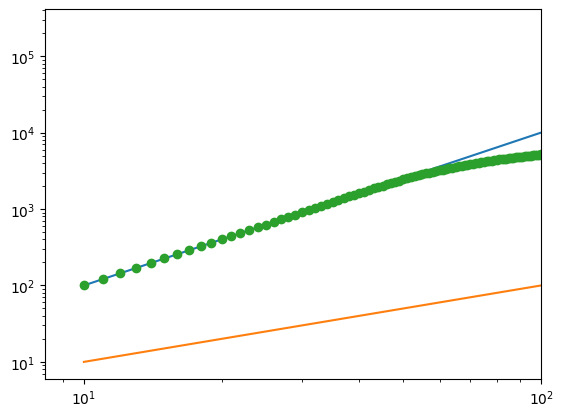

In [69]:
x = np.arange(10, len(mfpt)+10)
plt.plot(x, x**2)
plt.plot(x, x)

plt.loglog(x, mfpt, 'o')
plt.xlim(xmax=100)


In [55]:
L

32

In [56]:
# mfpt = []
for L in tqdm(range(32, 500)):
    diff = L - abs_t 
    bound = np.argwhere(diff == 0)
    first = []
    for u in tqdm(np.unique(bound[:,0])):
        first.append(bound[bound[:,0] == u, 1][0])
        
    mfpt.append(np.mean(first))

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9994 [00:00<?, ?it/s]

  0%|          | 0/9992 [00:00<?, ?it/s]

  0%|          | 0/9987 [00:00<?, ?it/s]

  0%|          | 0/9986 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9980 [00:00<?, ?it/s]

  0%|          | 0/9969 [00:00<?, ?it/s]

  0%|          | 0/9961 [00:00<?, ?it/s]

  0%|          | 0/9952 [00:00<?, ?it/s]

  0%|          | 0/9937 [00:00<?, ?it/s]

  0%|          | 0/9922 [00:00<?, ?it/s]

  0%|          | 0/9905 [00:00<?, ?it/s]

  0%|          | 0/9883 [00:00<?, ?it/s]

  0%|          | 0/9857 [00:00<?, ?it/s]

  0%|          | 0/9839 [00:00<?, ?it/s]

  0%|          | 0/9812 [00:00<?, ?it/s]

  0%|          | 0/9783 [00:00<?, ?it/s]

  0%|          | 0/9753 [00:00<?, ?it/s]

  0%|          | 0/9717 [00:00<?, ?it/s]

  0%|          | 0/9689 [00:00<?, ?it/s]

  0%|          | 0/9638 [00:00<?, ?it/s]

  0%|          | 0/9592 [00:00<?, ?it/s]

  0%|          | 0/9552 [00:00<?, ?it/s]

  0%|          | 0/9496 [00:00<?, ?it/s]

  0%|          | 0/9443 [00:00<?, ?it/s]

  0%|          | 0/9391 [00:00<?, ?it/s]

  0%|          | 0/9338 [00:00<?, ?it/s]

  0%|          | 0/9269 [00:00<?, ?it/s]

  0%|          | 0/9216 [00:00<?, ?it/s]

  0%|          | 0/9136 [00:00<?, ?it/s]

  0%|          | 0/9057 [00:00<?, ?it/s]

  0%|          | 0/8971 [00:00<?, ?it/s]

  0%|          | 0/8892 [00:00<?, ?it/s]

  0%|          | 0/8814 [00:00<?, ?it/s]

  0%|          | 0/8732 [00:00<?, ?it/s]

  0%|          | 0/8643 [00:00<?, ?it/s]

  0%|          | 0/8552 [00:00<?, ?it/s]

  0%|          | 0/8475 [00:00<?, ?it/s]

  0%|          | 0/8397 [00:00<?, ?it/s]

  0%|          | 0/8320 [00:00<?, ?it/s]

  0%|          | 0/8241 [00:00<?, ?it/s]

  0%|          | 0/8143 [00:00<?, ?it/s]

  0%|          | 0/8041 [00:00<?, ?it/s]

  0%|          | 0/7947 [00:00<?, ?it/s]

  0%|          | 0/7863 [00:00<?, ?it/s]

  0%|          | 0/7773 [00:00<?, ?it/s]

  0%|          | 0/7687 [00:00<?, ?it/s]

  0%|          | 0/7586 [00:00<?, ?it/s]

  0%|          | 0/7478 [00:00<?, ?it/s]

  0%|          | 0/7388 [00:00<?, ?it/s]

  0%|          | 0/7302 [00:00<?, ?it/s]

  0%|          | 0/7204 [00:00<?, ?it/s]

  0%|          | 0/7113 [00:00<?, ?it/s]

  0%|          | 0/7015 [00:00<?, ?it/s]

  0%|          | 0/6910 [00:00<?, ?it/s]

  0%|          | 0/6811 [00:00<?, ?it/s]

  0%|          | 0/6722 [00:00<?, ?it/s]

  0%|          | 0/6640 [00:00<?, ?it/s]

  0%|          | 0/6552 [00:00<?, ?it/s]

  0%|          | 0/6462 [00:00<?, ?it/s]

  0%|          | 0/6365 [00:00<?, ?it/s]

  0%|          | 0/6275 [00:00<?, ?it/s]

  0%|          | 0/6186 [00:00<?, ?it/s]

  0%|          | 0/6089 [00:00<?, ?it/s]

  0%|          | 0/5993 [00:00<?, ?it/s]

  0%|          | 0/5921 [00:00<?, ?it/s]

  0%|          | 0/5839 [00:00<?, ?it/s]

  0%|          | 0/5756 [00:00<?, ?it/s]

  0%|          | 0/5666 [00:00<?, ?it/s]

  0%|          | 0/5586 [00:00<?, ?it/s]

  0%|          | 0/5488 [00:00<?, ?it/s]

  0%|          | 0/5397 [00:00<?, ?it/s]

  0%|          | 0/5324 [00:00<?, ?it/s]

  0%|          | 0/5241 [00:00<?, ?it/s]

  0%|          | 0/5162 [00:00<?, ?it/s]

  0%|          | 0/5082 [00:00<?, ?it/s]

  0%|          | 0/5013 [00:00<?, ?it/s]

  0%|          | 0/4934 [00:00<?, ?it/s]

  0%|          | 0/4876 [00:00<?, ?it/s]

  0%|          | 0/4790 [00:00<?, ?it/s]

  0%|          | 0/4713 [00:00<?, ?it/s]

  0%|          | 0/4636 [00:00<?, ?it/s]

  0%|          | 0/4572 [00:00<?, ?it/s]

  0%|          | 0/4498 [00:00<?, ?it/s]

  0%|          | 0/4427 [00:00<?, ?it/s]

  0%|          | 0/4366 [00:00<?, ?it/s]

  0%|          | 0/4282 [00:00<?, ?it/s]

  0%|          | 0/4205 [00:00<?, ?it/s]

  0%|          | 0/4138 [00:00<?, ?it/s]

  0%|          | 0/4071 [00:00<?, ?it/s]

  0%|          | 0/3987 [00:00<?, ?it/s]

  0%|          | 0/3905 [00:00<?, ?it/s]

  0%|          | 0/3827 [00:00<?, ?it/s]

  0%|          | 0/3748 [00:00<?, ?it/s]

  0%|          | 0/3676 [00:00<?, ?it/s]

  0%|          | 0/3615 [00:00<?, ?it/s]

  0%|          | 0/3545 [00:00<?, ?it/s]

  0%|          | 0/3464 [00:00<?, ?it/s]

  0%|          | 0/3407 [00:00<?, ?it/s]

  0%|          | 0/3339 [00:00<?, ?it/s]

  0%|          | 0/3256 [00:00<?, ?it/s]

  0%|          | 0/3193 [00:00<?, ?it/s]

  0%|          | 0/3133 [00:00<?, ?it/s]

  0%|          | 0/3074 [00:00<?, ?it/s]

  0%|          | 0/3036 [00:00<?, ?it/s]

  0%|          | 0/2985 [00:00<?, ?it/s]

  0%|          | 0/2930 [00:00<?, ?it/s]

  0%|          | 0/2888 [00:00<?, ?it/s]

  0%|          | 0/2833 [00:00<?, ?it/s]

  0%|          | 0/2791 [00:00<?, ?it/s]

  0%|          | 0/2735 [00:00<?, ?it/s]

  0%|          | 0/2677 [00:00<?, ?it/s]

  0%|          | 0/2633 [00:00<?, ?it/s]

  0%|          | 0/2579 [00:00<?, ?it/s]

  0%|          | 0/2534 [00:00<?, ?it/s]

  0%|          | 0/2487 [00:00<?, ?it/s]

  0%|          | 0/2448 [00:00<?, ?it/s]

  0%|          | 0/2399 [00:00<?, ?it/s]

  0%|          | 0/2362 [00:00<?, ?it/s]

  0%|          | 0/2310 [00:00<?, ?it/s]

  0%|          | 0/2264 [00:00<?, ?it/s]

  0%|          | 0/2216 [00:00<?, ?it/s]

  0%|          | 0/2172 [00:00<?, ?it/s]

  0%|          | 0/2128 [00:00<?, ?it/s]

  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/2053 [00:00<?, ?it/s]

  0%|          | 0/2012 [00:00<?, ?it/s]

  0%|          | 0/1974 [00:00<?, ?it/s]

  0%|          | 0/1937 [00:00<?, ?it/s]

  0%|          | 0/1901 [00:00<?, ?it/s]

  0%|          | 0/1868 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

  0%|          | 0/1799 [00:00<?, ?it/s]

  0%|          | 0/1762 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1696 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1623 [00:00<?, ?it/s]

  0%|          | 0/1582 [00:00<?, ?it/s]

  0%|          | 0/1548 [00:00<?, ?it/s]

  0%|          | 0/1512 [00:00<?, ?it/s]

  0%|          | 0/1486 [00:00<?, ?it/s]

  0%|          | 0/1452 [00:00<?, ?it/s]

  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/1382 [00:00<?, ?it/s]

  0%|          | 0/1355 [00:00<?, ?it/s]

  0%|          | 0/1322 [00:00<?, ?it/s]

  0%|          | 0/1289 [00:00<?, ?it/s]

  0%|          | 0/1265 [00:00<?, ?it/s]

  0%|          | 0/1238 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1187 [00:00<?, ?it/s]

  0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1126 [00:00<?, ?it/s]

  0%|          | 0/1104 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1057 [00:00<?, ?it/s]

  0%|          | 0/1037 [00:00<?, ?it/s]

  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/991 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/928 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/853 [00:00<?, ?it/s]

  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/822 [00:00<?, ?it/s]

  0%|          | 0/806 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/692 [00:00<?, ?it/s]

  0%|          | 0/671 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/626 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/522 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/371 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/home/gorka/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gorka/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [30]:
bound[bound[:,0] == u, 1][0]

86

In [28]:
np.mean(first)

/home/gorka/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (100,) (300,) 

# NBDEV Export

In [43]:
from nbdev.export import notebook2script
notebook2script()

Converted cluster_launch.ipynb.
Converted diffusion_walks.ipynb.
Converted environment.ipynb.
Converted theoretical_policy.ipynb.
